## Pets Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

libraries

In [2]:
import fastai as f
import fastai.vision as fv

### The Data

the ```fastai.vision``` has a helper to download dataset and the urls of the datasets

In [3]:
help(fv.untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [4]:
fv.URLs()

available datasets are ```S3_NLP```, ```S3_COCO```, ```MNIST_SAMPLE```, ```MNIST_TINY```, ```IMDB_SAMPLE```, ```ADULT_SAMPLE```, ```ML_SAMPLE```, ```PLANET_SAMPLE```, ```CIFAR```, ```PETS```, ```MNIST```, and we're gonna use ```PETS``` for this classification

In [5]:
fv.URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

the ```untar_data``` will download and save it to a path

In [6]:
path = fv.untar_data(url=fv.URLs.PETS)

In [7]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [9]:
path_anno = path/'annotations'
path_img = path/'images'

get the files, using ```get_image_files```

In [10]:
fnames = fv.get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_60.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_139.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_54.jpg')]

the labels are in the filename, we can use ```regex``` to parse them

In [11]:
pat = r'([^/]+)_\d+\.jpg$'

In [12]:
help(fv.ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path:Union[pathlib.Path, str], fnames:Collection[pathlib.Path], pat:str, valid_pct:float=0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



In [13]:
data = fv.ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=fv.get_transforms(), size=224)

it will help the model if the image RGB channels are normalized so each channel has mean of 0 and std dev of 1

In [14]:
data.normalize(fv.imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
samoyed,pug,Bombay,beagle,pomeranian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
great_pyrenees,english_setter,saint_bernard,pomeranian,staffordshire_bull_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

let's take a look at the data

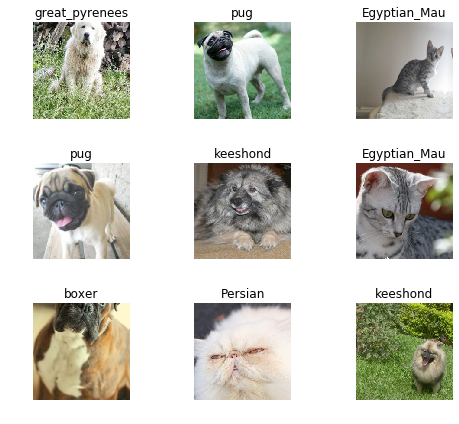

In [15]:
data.show_batch(rows=3, figsize=(7,6))

the labels

In [16]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [17]:
len(data.classes)

37

### Train the Model

We're gonna do transfer learning using ```resnet34``` model.

In [18]:
model = fv.models.resnet34
error_rate = f.metrics.error_rate

the ```fastai.vision``` module provides ```resnet34``` model that we can directly use, and we'll use the ```error_rate``` as the metric to print out from the training as predefined in ```fastai``` module.

In [19]:
learn = fv.learner.create_cnn(data, model, metrics=error_rate)

let's train it with 4 epoch.

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
1,1.382003,0.310331,0.098106,02:56
2,0.557999,0.202541,0.063599,01:35
3,0.356056,0.180021,0.060217,01:34
4,0.259276,0.171911,0.056157,01:35


save the trained state of the learner.

In [21]:
learn.save('stage-1')

### Result

We can check the result interpretation as the following.

In [22]:
interp = fv.learner.ClassificationInterpretation.from_learner(learn)

Check the most wrong, so confident but wrong.

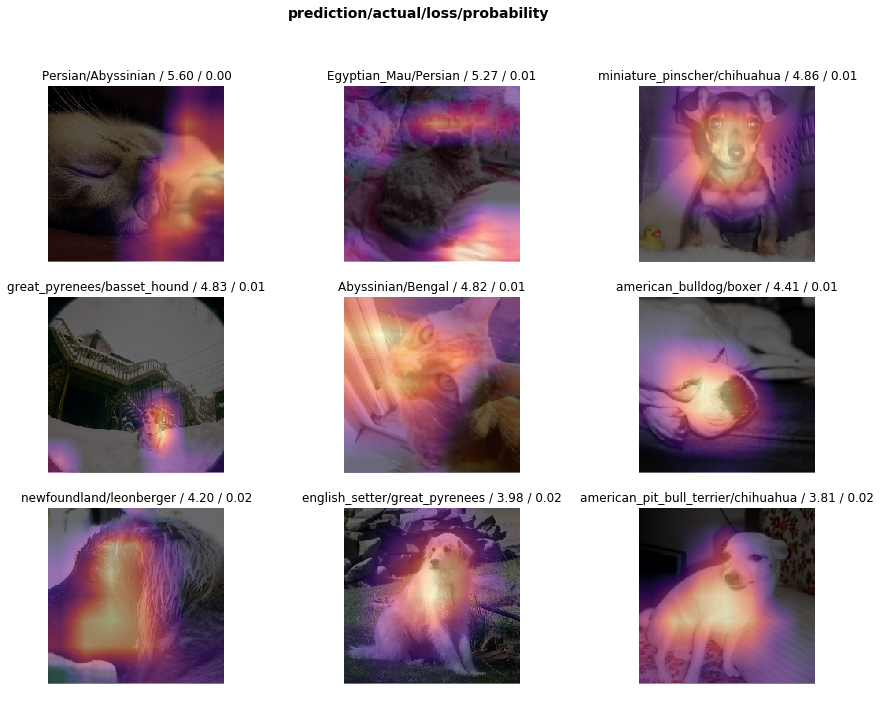

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

We can also check the confusion matrix

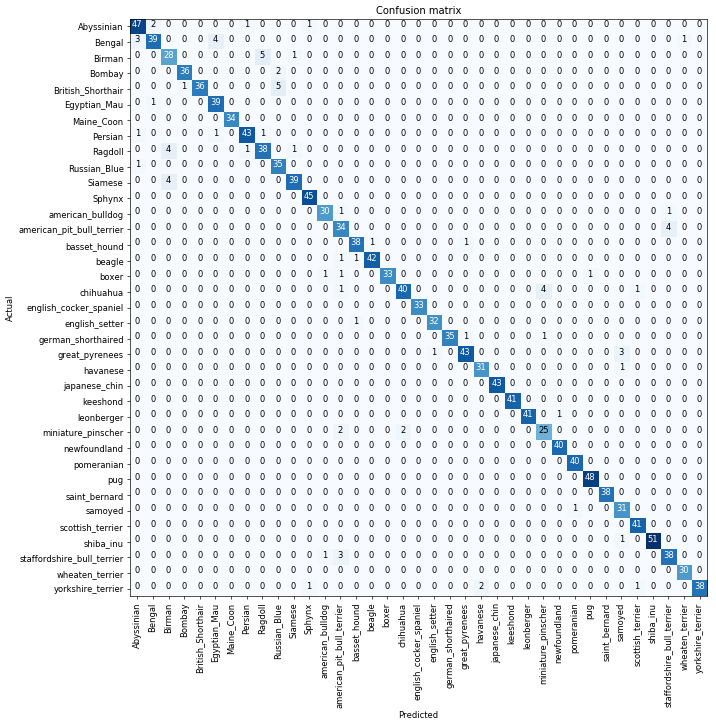

In [24]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

or we can list them

In [26]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Ragdoll', 'Birman', 4),
 ('Siamese', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Bengal', 'Abyssinian', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bombay', 'Russian_Blue', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('yorkshire_terrier', 'havanese', 2)]

### Unfreezing, Fine Tuning, and Learning Rates

We will ```unfreeze``` the model to train it more on all layers of the model.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
1,0.519992,0.285363,0.080514,01:37


Previously the ```error_rate``` = 0.056157, it means our model got worse! What happened?

It happened because we tried to train all layers with same speed or ```learning rate```. However what we want to update the most are actually the last layers. The early layers contain basic shapes which already good enough we should not update them much if at all.

Let's load the ```stage-1``` state we previously saved.

In [29]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
samoyed,pug,Bombay,beagle,pomeranian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
great_pyrenees,english_setter,saint_bernard,pomeranian,staffordshire_bull_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

We can use learning rate finder already available in the ```learn``` object.

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


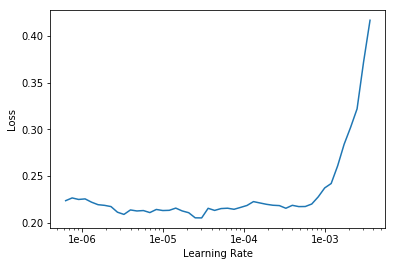

In [31]:
learn.recorder.plot()

As we can see that the learning rate affects the loss during training, in this case the loss starts shooting off when the learning rate is 0.001 or higher. In fact, the default learning rate of ```fit_one_cycle``` is 0.003 which explains why our model got worse.

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
1,0.247123,0.162911,0.053451,01:37
2,0.212498,0.160845,0.052774,01:37
